# Advanced Lane Finding Notebook #
This project calibrates images from a vehicles central camera for use in detecting lanes.

## Building the Lane Finding Pipeline ##

### Imports and Constants ###

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import operator
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

IMAGE_HEIGHT = 720
IMAGE_WIDTH = 1280
LANE_LENGTH_m = 30
LANE_WIDTH_m = 3.7
LANE_WIDTH_pixel = 700
LANE_HALF_W_pixel = LANE_WIDTH_pixel/2
M_PER_PIXEL_y = LANE_LENGTH_m/IMAGE_HEIGHT 
M_PER_PIXEL_x = LANE_WIDTH_m/LANE_WIDTH_pixel

### Display Functions ###

In [2]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(8, 4.5))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=12) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=12)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotWithVerticles(ncols, images, offset, titles, cmaps):
    f, axes = plt.subplots(1, ncols, figsize=(16, 9))
    for idx, img in enumerate(images):
        axes[idx].imshow(img, cmap=cmaps[idx])
        axes[idx].set_title(titles[idx], fontsize=12)
        xL = offset
        xR = IMAGE_WIDTH-offset
        axes[idx].plot((xL, xL), (0, IMAGE_HEIGHT), 'r-')
        axes[idx].plot((xR, xR), (0, IMAGE_HEIGHT), 'r-')
    plt.show()
    return

def plotCreateSecondOrderXY(leftCoeff, rightCoeff):
    y = np.linspace(0, IMAGE_HEIGHT-1, IMAGE_HEIGHT)
    xL = leftCoeff[0]*y**2 + leftCoeff[1]*y + leftCoeff[2]
    xR = rightCoeff[0]*y**2 + rightCoeff[1]*y + rightCoeff[2]
    return xL, xR, y

def plotWithSecondOrder(img, leftCoeff, rightCoeff, title):
    xL, xR, y = plotCreateSecondOrderXY(leftCoeff, rightCoeff)
    plt.imshow(img, cmap='gray')
    plt.plot(xL, y, color='yellow')
    plt.plot(xR, y, color='yellow')
    plt.ylim(IMAGE_HEIGHT, 0)
    plt.xlim(0, IMAGE_WIDTH)
    plt.title(title)
    plt.show()
    return

def plotTwoWithFirstFilled(img1, img2, leftCoeff, rightCoeff, title1, title2):
    xL, xR, y = plotCreateSecondOrderXY(leftCoeff, rightCoeff)  
    L = leftCoeff[0]*IMAGE_HEIGHT**2 + leftCoeff[1]*IMAGE_HEIGHT + leftCoeff[2]
    R = rightCoeff[0]*IMAGE_HEIGHT**2 + rightCoeff[1]*IMAGE_HEIGHT + rightCoeff[2]
    verts = [(L,0)] + list(zip(xL, y)) + list(zip(reversed(xR), reversed(y))) + [(R,0)]
    poly = patches.Polygon(verts, facecolor='green', edgecolor='yellow')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 9))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(title1, fontsize=12)
    axes[0].add_patch(poly)
    
    axes[1].imshow(img2)
    axes[1].set_title(title2, fontsize=12)
    
    plt.ylim(IMAGE_HEIGHT, 0)
    plt.xlim(0, IMAGE_WIDTH)
    plt.show() 
    return

### Testing Images ###
Load the images used to prove out the lane finding pipeline

(720, 1280, 3)


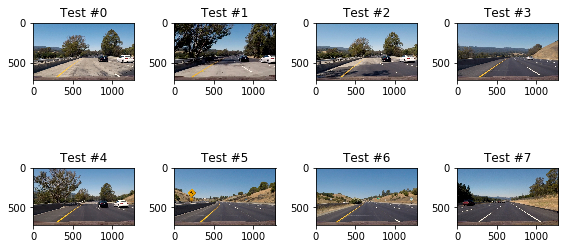

In [3]:
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testImages = testImages+getTestingImages('test_images/straight_lines*.jpg')
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)
    
print(testImages[0].shape)
plotMany(2, 4, testImages, testTitles, testCmap)

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [4]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
    return

Process all the provided calibration images and run the calibration.

Calibration points found in 17 of 20 images


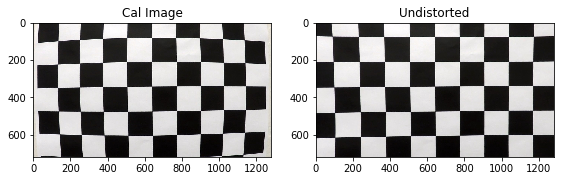

In [5]:
iOrig = mpimg.imread('camera_cal/calibration1.jpg')

images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

ret, cameraMtx, distCoeffs, rotVecs, transVecs = cv2.calibrateCamera(
    worldPoints, imagePoints, iOrig.shape[0:2], None, None)

iUndistort = cv2.undistort(iOrig, cameraMtx, distCoeffs, None, cameraMtx)
plotTwo(iOrig, iUndistort, 'Cal Image', 'Undistorted')

### Lane Finding Pipeline ###
Coding up and testing the individual pieces of the pipeline

#### Distortion Correction ####
_Functions for undistortion:_

In [6]:
def undistortImage(img):
    # Undistort the image by refining the camera matrix,
    # running the function, then cropping to the region of interest
    return cv2.undistort(img, cameraMtx, distCoeffs, None, cameraMtx)

_Testing/Plotting Cell:_

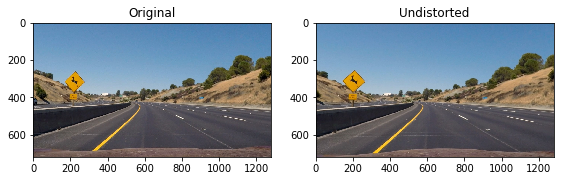

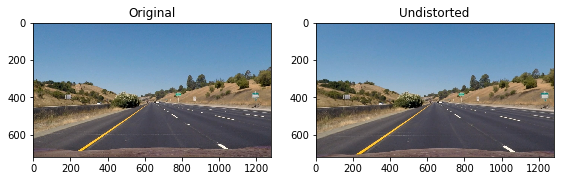

In [7]:
testUndistorteds = []
for img in testImages:
    testUndistorteds.append(undistortImage(img))

samples = random.sample(testImages, 2)
plotTwo(samples[0], undistortImage(samples[0]),
        'Original', 'Undistorted')
plotTwo(samples[1], undistortImage(samples[1]),
        'Original', 'Undistorted')

# Save off a straight line image
mpimg.imsave('test_images/straight_lines1_undistorted.png', 
            testUndistorteds[6])

#### Binary Image Threshold Creation ####
_Functions to create filtered binary images:_

Please refer to ThresholdTesting.ipynb for more experiments and testing with other threshold options.

In [8]:
# ThresholdTesting.ipynb used to determine the following:
def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def combineThresholdsForPlots(img):
    # Combine thresholds for testing with visualization
    # Convert to CIELAB color space and use the L channel for whites
    # and the b channel (blues to yellows) for yellows
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    whiteB = applyThreshold(lab[:,:,0], (210,255)) 
    yellowB = applyThreshold(lab[:,:,2], (150,255))
    combined = np.zeros_like(whiteB)
    combined[((whiteB == 1)|(yellowB == 1))] = 1
    return whiteB, yellowB, combined 

def combineThresholds(img):
    # Combine thresholds for pipeline use
    combine1, combine2, combined = combineThresholdsForPlots(img)
    return combined 

_Testing/Plotting Cells:_

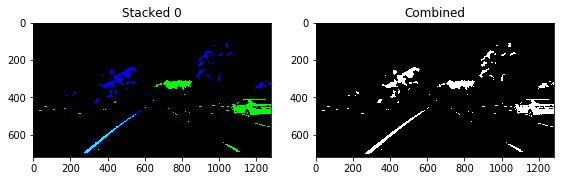

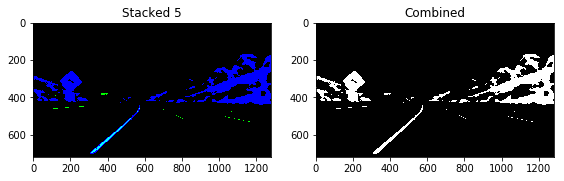

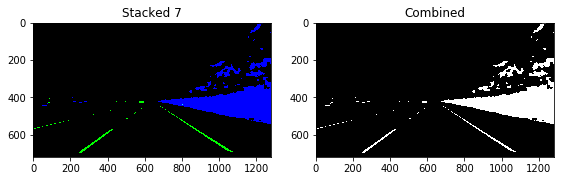

In [9]:
samples = [0, 5, 7]
testCombined = []

for idx, img in enumerate(testUndistorteds):
    # Create the combined threshold
    bin1, bin2, combined = combineThresholdsForPlots(img)
    testCombined.append(combined)
    
    if idx in samples:
        stacked = np.dstack((np.zeros_like(bin1), bin1, bin2))
        plotMany(1, 2, [stacked,combined], ["Stacked {}".format(idx),'Combined'], [None,'gray'])

#### Perspective Transformation ####
_Functions to transform the perspective of the image:_ 

In [10]:
birdsEyeOffset = np.absolute(LANE_WIDTH_pixel - IMAGE_WIDTH)/2
birdsEyeSrc = np.float32([(577, 460), (709, 460), (1018, 650), (birdsEyeOffset, 650)])
birdsEyeDst = np.float32([[birdsEyeOffset, 0], [IMAGE_WIDTH-birdsEyeOffset, 0],
                          [IMAGE_WIDTH-birdsEyeOffset, IMAGE_HEIGHT], [birdsEyeOffset, IMAGE_HEIGHT]]) 

def warpToBirdsEye(img):
    # Perform a perspective transform for the region of interest
    M = cv2.getPerspectiveTransform(birdsEyeSrc, birdsEyeDst)
    return cv2.warpPerspective(img, M, (IMAGE_WIDTH, IMAGE_HEIGHT))

def warpFromBirdsEye(img):
    Minv = cv2.getPerspectiveTransform(birdsEyeDst, birdsEyeSrc)
    return cv2.warpPerspective(img, Minv, (IMAGE_WIDTH, IMAGE_HEIGHT))
    

_Testing/Plotting Cells:_

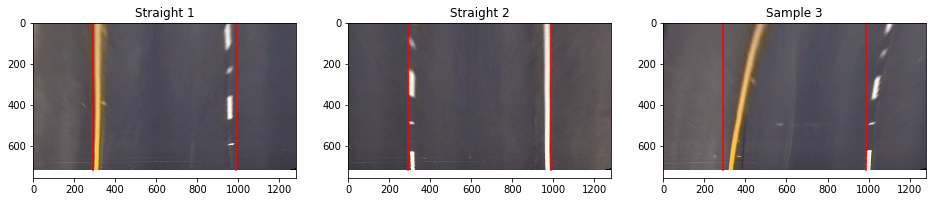

In [11]:
iStraight1 = warpToBirdsEye(testUndistorteds[6])
iStraight2 = warpToBirdsEye(testUndistorteds[7])
iCurve = warpToBirdsEye(testUndistorteds[3])
plotWithVerticles(3, [iStraight1, iStraight2, iCurve], birdsEyeOffset, 
                  ['Straight 1','Straight 2','Sample 3'], [None, None, None])

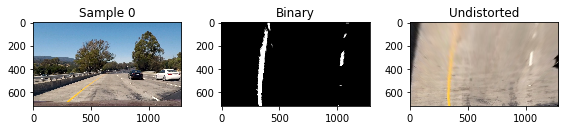

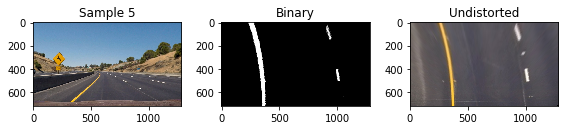

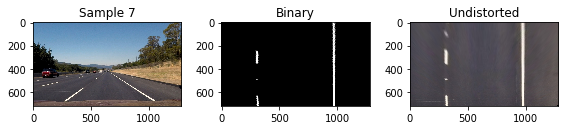

In [12]:
testBirdsEye = []

for idx, img in enumerate(testCombined):
    # Perform the perspective
    warped = warpToBirdsEye(img)
    testBirdsEye.append(warped)
    
    if idx in samples:
        cwarped = warpToBirdsEye(testUndistorteds[idx]) 
        plotMany(1, 3, [testImages[idx], warped, cwarped], 
                 ["Sample {}".format(idx), "Binary", "Undistorted"],
                 [None, 'gray', None])

#### Lane Line Identification ####
_Functions to find the lane lines within the images:_ 

In [13]:
n_windows = 8
windowHeight = np.int(IMAGE_HEIGHT/n_windows)
windowWidth = 140

def findLaneStarts(img):
    # Calculate the histogram to use the peaks 
    # as the start of the lanes
    histogram = np.sum(img[int(IMAGE_HEIGHT/2):,:], axis=0)
    center = np.int(histogram.shape[0]/2)
    xLeft = np.argmax(histogram[:center])
    xRight = center + np.argmax(histogram[center:])
    return xLeft, xRight

def findLaneInWindow(x, xDelta, y, nonzero):
    # Find the individual lane within the window
    y_nonzero = np.array(nonzero[0])
    x_nonzero = np.array(nonzero[1])

    # Locate one lane within the frame of a window
    windowHalfWidth = int(windowWidth/2)
    windowLeft = x - windowHalfWidth;
    windowRight = x + windowHalfWidth
    windowTop = y - windowHeight
    windowBottom = y
    
    # Find the nonzero pixels in x and y within the window
    laneIdx = ((y_nonzero >= windowTop) & 
               (y_nonzero < windowBottom) & 
               (x_nonzero >= windowLeft) &  
               (x_nonzero <= windowRight)).nonzero()[0]
    
    if len(laneIdx) > 0:
        xNext = np.int(np.mean(x_nonzero[laneIdx]))
        xDelta = (xDelta + (xNext-x))/2
    else:
        xNext = x + xDelta
        
    return xNext, xDelta, laneIdx, (windowLeft, windowBottom)

def findInitialLaneInImage(img, xStart, visualizeOn=False):
    # Find the individual lane within the image by
    # looking through windows
    nonzero = img.nonzero()
    y_nonzero = np.array(nonzero[0])
    x_nonzero = np.array(nonzero[1])
    laneIndices = []
    
    # Step through the windows one by one
    x = xStart
    xDelta = 0
    for w in range(n_windows+1):
        y = IMAGE_HEIGHT-(w)*windowHeight
        x, xDelta, idx, windowCorner = findLaneInWindow(x, xDelta, y, nonzero)
        laneIndices.append(idx)
        
        # Plot rectangles if enabled
        if visualizeOn:
            windowFrame = patches.Rectangle(windowCorner, 
                                            windowWidth, 
                                            windowHeight, 
                                            fill=False, 
                                            edgecolor='green')
            plt.gca().add_patch(windowFrame)
    
    # Flatten the indices to fit the polynomial
    laneIndices = np.concatenate(laneIndices)
    laneCoeff = np.polyfit(y_nonzero[laneIndices],
                           x_nonzero[laneIndices], 2)    
    return laneCoeff, x_nonzero[laneIndices], y_nonzero[laneIndices]

def findLaneInImage(img, laneCoeff):
    # Find the individual lane within the image by either
    # looking in the windows or using the second order polynomial
    nonzero = img.nonzero()
    y_nonzero = np.array(nonzero[0])
    x_nonzero = np.array(nonzero[1])
    laneIndices = (
        (x_nonzero > 
        (laneCoeff[0]*(y_nonzero**2) + 
         laneCoeff[1]*y_nonzero + laneCoeff[2] - windowWidth)) 
        & 
        (x_nonzero < 
        (laneCoeff[0]*(y_nonzero**2) + 
         laneCoeff[1]*y_nonzero + laneCoeff[2] + windowWidth))) 

    # Fit the polynomial to the new indices
    xs = x_nonzero[laneIndices]
    ys = y_nonzero[laneIndices]
    if len(xs) > 0 and len(ys) > 0:
        laneCoeff = np.polyfit(ys, xs, 2)
    else:
        laneCoeff = []
    return laneCoeff, xs, ys

_Testing/Plotting Cells:_

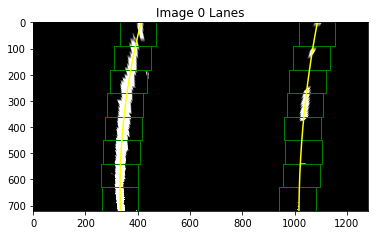

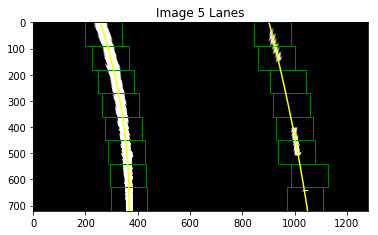

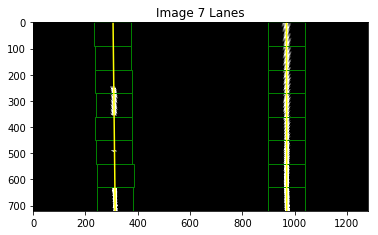

In [14]:
for idx, img in enumerate(testBirdsEye):
    if idx in samples:
        # Find the lanes
        xLeft, xRight = findLaneStarts(img)    
        leftCoeff, xs, ys = findInitialLaneInImage(img, xLeft, True)
        rightCoeff, xs, ys = findInitialLaneInImage(img, xRight, True)
        plotWithSecondOrder(img, leftCoeff, rightCoeff, "Image {} Lanes".format(idx))

#### Curvature and Location Estimation ####
_Functions to determine the lane curvature and location within the images:_ 

In [15]:
def calculateCurve(coeff, yEval):
    # Convert the valid index values to real world to fit
    # a polynomial to use to calculate the radius
    radius_m = 0
    if len(leftCoeff) ==3 and len(rightCoeff) == 3:
        ys = np.linspace(0, IMAGE_HEIGHT-1, IMAGE_HEIGHT)
        xs = coeff[0]*ys**2 + coeff[1]*ys + coeff[2]    
        
        worldCoeff = np.polyfit(ys*M_PER_PIXEL_y, xs*M_PER_PIXEL_x, 2)
        
        numerator = (1+(2*worldCoeff[0]*yEval*M_PER_PIXEL_y + worldCoeff[1])**2)**1.5
        radius_m = numerator/np.absolute(2*worldCoeff[0])  
    return radius_m

def estimateCenterOffset(leftCoeff, rightCoeff):
    y_eval = IMAGE_HEIGHT-1
    xLeft = leftCoeff[0]*y_eval**2 + leftCoeff[1]*y_eval + leftCoeff[2]
    xRight = rightCoeff[0]*y_eval**2 + rightCoeff[1]*y_eval + rightCoeff[2]
    cameraPosition = IMAGE_WIDTH/2
    midpoint = (xRight-xLeft)/2 + xLeft
    offset = (cameraPosition - midpoint)*M_PER_PIXEL_x
    return offset

_Testing/Plotting Cells:_

In [16]:
for idx, img in enumerate(testBirdsEye):
    if idx in samples:
        # Find the lanes
        xLeft, xRight = findLaneStarts(img)    
        lCoeff, xs, ys = findInitialLaneInImage(img, xLeft)
        lRadius = calculateCurve(lCoeff, IMAGE_HEIGHT-1) 
        
        rCoeff, xs, ys = findInitialLaneInImage(img, xRight)
        rRadius = calculateCurve(rCoeff, IMAGE_HEIGHT-1)
        
        carOffset = estimateCenterOffset(lCoeff, rCoeff) 
        
        print("Image {}:".format(idx))
        print("\tRadius = {:.2f} m, {:.2f} m".format(lRadius, rRadius))
        print("\tCenter Offset = {:.2f} m".format(carOffset))             

Image 0:
	Radius = 819.40 m, 1301.58 m
	Center Offset = -0.19 m
Image 5:
	Radius = 723.50 m, 2321.67 m
	Center Offset = -0.36 m
Image 7:
	Radius = 401449.38 m, 59311.38 m
	Center Offset = -0.01 m


### Marking Lanes on Images ###
_First create a class to store the line information_

In [17]:
class LaneLine():
    def __init__(self, isLeft, printDebug=False):
        self.isLeft = isLeft
        self.init = False
        self.detected = False
        self.xLatest = [] 
        self.yLatest = []
        self.radius_m = 0
        self.radiusG = .80 #Exponential smoothing used to track radius
        
        #calculation helpers
        self.xMin = 0
        self.xMax = 0
        self.yEval = 0
                
        #polynomial coefficients
        self.coeff = []
        self.coeffDelta = np.array([0,0,0], dtype='float')   
        
        #Variable to display for testing
        self.printDebug = printDebug
        return
        
    def initialize(self, coeff, xs, ys):
        self.xLatest = xs
        self.yLatest = ys
        self.coeff = coeff
        self.radius_m = calculateCurve(coeff, self.yEval)
        
        lExpected = (IMAGE_WIDTH/2) - LANE_HALF_W_pixel
        rExpected = (IMAGE_WIDTH/2) + LANE_HALF_W_pixel
        xExpected = lExpected if self.isLeft else rExpected
        self.xMin = xExpected - windowWidth/2
        self.xMax = xExpected + windowWidth/2
        
        self.yEval = IMAGE_HEIGHT-1
        self.init = True
        return
    
    def reset(self):
        self.init = False
        self.detected = False
        self.xLatest = []
        self.yLatest = []
        self.coeff = []
        self.coeffDelta = np.array([0,0,0], dtype='float')   
        self.radius_m = 0 
        return
    
    def isValid(self, coeff):
        x = coeff[0]*self.yEval**2 + coeff[1]*self.yEval + coeff[2]
        valid = (self.xMin <= x <= self.xMax)
        return valid

    def update(self, coeff, xs, ys):
        if self.isValid(coeff):
            self.coeffDelta = np.absolute(np.subtract(self.coeff, coeff))
            self.coeff = np.divide(np.add(self.coeff, coeff),2)
            radius = calculateCurve(self.coeff, self.yEval)
            self.radius_m = self.radiusG * radius + (1-self.radiusG) * self.radius_m
        else:
            self.detected = False
            if self.printDebug:print('\tINVALID m')
        self.xLatest = xs
        self.yLatest = ys
        return
    
    def findInImageInitial(self, img):
        xLeft, xRight = findLaneStarts(img) 
        startL, startR = findLaneStarts(img)
        xSeed = startL if self.isLeft else startR
        coeff, xs, ys = findInitialLaneInImage(img, xSeed)
        return coeff, xs, ys
                
    def findInImage(self, img):
        if self.printDebug:print("Lane {}".format(('Left' if self.isLeft else 'Right')))
        if self.init == False:
            coeff, xs, ys = self.findInImageInitial(img)
            self.initialize(coeff, xs, ys)
        else:
            coeff, xs, ys = findLaneInImage(img, self.coeff)
            self.detected = (len(xs) > 0)
            if self.detected:
                if self.printDebug:print("\tDetected")
                self.update(coeff, xs, ys)
        return
    
    def adjust(self, other):
        # Modify the values using information from the other line
        sign = -1 if self.isLeft else 1
        maxDelta = np.amax(self.coeffDelta)
        otherDelta = np.amax(other.coeffDelta)
        if other.detected and (not self.detected or (maxDelta > otherDelta)):
            if self.printDebug:print("Adjust {}".format(('Left' if self.isLeft else 'Right')))
            xNew = np.concatenate((other.xLatest+(sign*LANE_WIDTH_pixel), self.xLatest))
            yNew = np.concatenate((other.yLatest, self.yLatest))            
            if len(xNew) > 0 and len(yNew) > 0:
                newCoeff = np.polyfit(yNew, xNew, 2)
            else:
                newCoeff = []
            self.update(newCoeff, xNew, yNew)
        return
            

_Functions to draw on the colored images:_ 

In [18]:
def createLaneDrawing(birdsEyeImg, undistortedImg, leftLane, rightLane):
    #Create the green shape for highlighting the lane
    birdsEyeZero = np.zeros_like(birdsEyeImg).astype(np.uint8)
    birdsEyeColor = np.dstack((birdsEyeZero, birdsEyeZero, birdsEyeZero))
    
    xL, xR, y = plotCreateSecondOrderXY(leftLane.coeff, rightLane.coeff)
    pointsL = np.array([np.transpose(np.vstack([xL, y]))])
    pointsR = np.array([np.flipud(np.transpose(np.vstack([xR, y])))])
    pts = np.hstack((pointsL, pointsR))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(birdsEyeColor, np.int_([pts]), (0,255, 0))
    laneImg = warpFromBirdsEye(birdsEyeColor)
    
    # Combine the drawing with the undistorted image
    resultImg = cv2.addWeighted(undistortedImg, 1, laneImg, 0.3, 0)
    
    # Write the radius and offset
    textRadius = "Radius ~ {:.2f} km".format((leftLane.radius_m+rightLane.radius_m)/2000)
    resultImg = cv2.putText(resultImg, textRadius, (10,100), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 4)
    
    carOffset = estimateCenterOffset(leftLane.coeff, rightLane.coeff)
    textOffsets = "Car Offset ~ {:.2f} m from Center".format(carOffset)
    resultImg = cv2.putText(resultImg, textOffsets, (10,200), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 4)
    
    return resultImg

_Testing/Plotting Cell:_

Lane Left
Lane Right


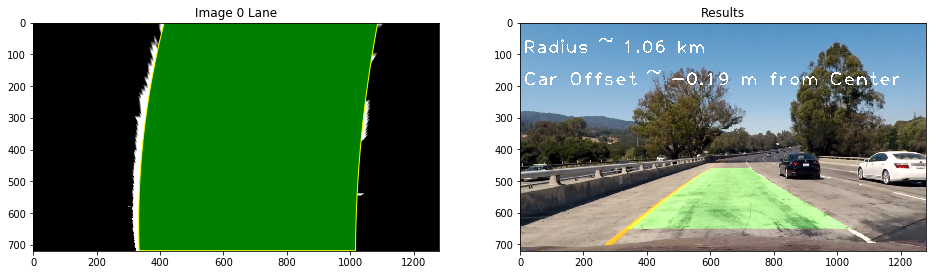

Lane Left
	Detected
Lane Right
	Detected
Adjust Left


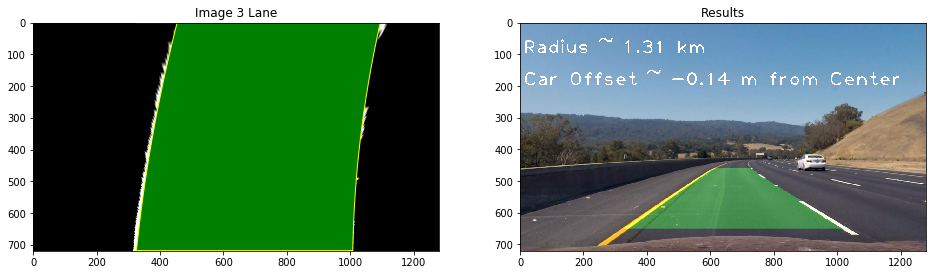

In [19]:
xLeftStart, xRightStart = findLaneStarts(testBirdsEye[0])

testLeftLane = LaneLine(True, True)
testRightLane = LaneLine(False, True)
    
track = [3,0]
for idx, img in enumerate(testBirdsEye):
    if idx in track:
        testLeftLane.findInImage(img)
        testRightLane.findInImage(img)
        testLeftLane.adjust(testRightLane)
        testRightLane.adjust(testLeftLane)        
        testResult = createLaneDrawing(img, testUndistorteds[idx], testLeftLane, testRightLane)
        
        plotTwoWithFirstFilled(img, testResult, testLeftLane.coeff, testRightLane.coeff, 
                               "Image {} Lane".format(idx), 'Results')

## Lane Finding Pipeline ##
Putting together the functions definded above into a pipeline
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation
6. Image markup

In [20]:
leftLane = LaneLine(True)
rightLane = LaneLine(False)

def findLanes(img):
    
    undistorted = undistortImage(img)
    binary = combineThresholds(undistorted)
    warped = warpToBirdsEye(binary)
    
    leftLane.findInImage(warped)
    rightLane.findInImage(warped)
    leftLane.adjust(rightLane)
    rightLane.adjust(leftLane)
    
    resultImg = createLaneDrawing(warped, undistorted, leftLane, rightLane)
    return resultImg

_Testing/Plotting Cell:_

In [21]:
leftLane.reset()
rightLane.reset()
testing = 'output_images/project_test.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(35,42)
projectClip = clip1.fl_image(findLanes)
%time projectClip.write_videofile(testing, audio=False)
HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(testing))

[MoviePy] >>>> Building video output_images/project_test.mp4
[MoviePy] Writing video output_images/project_test.mp4


 99%|█████████▉| 175/176 [00:14<00:00, 12.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_test.mp4 

CPU times: user 36.3 s, sys: 252 ms, total: 36.6 s
Wall time: 15 s


## Video Processing ##

This section of the notebook processes the entire test videos

In [22]:
def processVideo(videoName, outputName):
    # Remove any artifacts from previous runs
    leftLane.reset()
    rightLane.reset()

    clip1 = VideoFileClip(videoName)
    projectClip = clip1.fl_image(findLanes)
    %time projectClip.write_videofile(outputName, audio=False)

In [23]:
results = 'output_images/project_results.mp4'
processVideo("project_video.mp4", results)

[MoviePy] >>>> Building video output_images/project_results.mp4
[MoviePy] Writing video output_images/project_results.mp4


100%|█████████▉| 1260/1261 [01:45<00:00, 12.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_results.mp4 

CPU times: user 4min 24s, sys: 1.22 s, total: 4min 25s
Wall time: 1min 46s


In [24]:
HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(results))

In [25]:
challenge = 'output_images/challenge_results.mp4'
processVideo("challenge_video.mp4", challenge)

[MoviePy] >>>> Building video output_images/challenge_results.mp4
[MoviePy] Writing video output_images/challenge_results.mp4


100%|██████████| 485/485 [00:38<00:00, 12.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_results.mp4 

CPU times: user 1min 39s, sys: 604 ms, total: 1min 39s
Wall time: 39.7 s


In [26]:
HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(challenge))

In [27]:
harder = 'output_images/harder_challenge_results.mp4'
processVideo("harder_challenge_video.mp4", harder)

[MoviePy] >>>> Building video output_images/harder_challenge_results.mp4
[MoviePy] Writing video output_images/harder_challenge_results.mp4


100%|█████████▉| 1199/1200 [01:57<00:00, 10.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_results.mp4 

CPU times: user 4min 28s, sys: 1.37 s, total: 4min 30s
Wall time: 1min 57s


In [28]:
HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(harder))